0

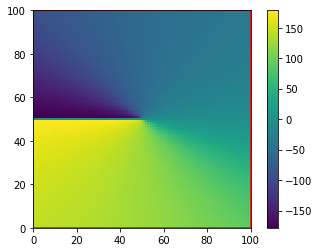

In [1]:
import scipy as sc
from scipy.sparse import *
from scipy.sparse.linalg import *
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt


from gstlearn import *
import gstlearn.plot as myplot


verbose = False

def fa(x,y,a,b):
    return a*x + b*y

def spirale(db,a=0,b=-1.4,c=1.,d=1.,plot = False):
    x1c = np.array(db.getField("x1")) #getField ou mieux getCoords coords = workingDb.getCoords()
    x2c = np.array(db.getField("x2")) 
    u1=fa(x1c-50,x2c-50,a,b)
    u2=fa(x1c-50,x2c-50,c,d)
    shape = db.getNXs()
    norm = np.sqrt(u1**2+u2**2)
    ind = norm>0
    theta = np.zeros_like(norm)
    theta[norm>0] = np.arccos(u2[ind]/norm[ind])/np.pi*180*np.sign(u1[ind])
    x1c=x1c.reshape(shape)
    x2c=x2c.reshape(shape)
    u1=u1.reshape(shape)
    u2=u2.reshape(shape)
    if plot:
        plt.quiver(x1c,x2c,u1,u2)
        plt.axis("equal")
        plt.show()
    return theta


# Draw a vector field

# In[ ]:


#Création de la grille de représentation
workingDbc = DbGrid.create([10,10],[10,10])
spirale(workingDbc,plot=False);


resultDb = DbGrid.create([101,101],[1,1]) 
x1 = np.array(resultDb.getField("x1")) #getField ou mieux getCoords coords = workingDb.getCoords()
x2 = np.array(resultDb.getField("x2")) 
theta = spirale(resultDb)
Scale1=5*np.ones(theta.size)
Scale2=20*np.ones(theta.size)
iatt = resultDb.addFields(theta,"theta")
iatt = resultDb.addFields(Scale1,"Scale1")
iatt = resultDb.addFields(Scale2,"Scale2")
resultDb.setLocator(['theta','Scale1','Scale2'],ELoc.NOSTAT)


myplot.grid(resultDb,"theta")



np.random.seed(124)
ndat=10000
coords=np.random.uniform(1,99,size=(ndat,2))
dat = Db()
dat.addFields(coords[:,0],"X")
dat.addFields(coords[:,1],"Y")
dat.setLocator(['X','Y'],ELoc.X)


# Création du modèle. Attention le grand axe doit etre fourni en premier: il correspond à la direction pointée par l'angle 'theta'.

model = Model.createFromDb(resultDb)
cova = CovAniso(ECov.BESSEL_K,model.getContext()) #Alias ECov.MATERN
cova.setScales([4,81])
model.addCova(cova)


NoStat = NoStatArray(["A","S1","S2"],resultDb)
model.addNoStat(NoStat)



workingDb = DbGrid.create([101,101],[1,1]) 
mesh = MeshETurbo(workingDb)




S = ShiftOpCs(mesh, model, resultDb)

S.initGradFromMesh(mesh,model,resultDb)



In [2]:
ind=1051 #indice du vertex

ipar = 1
if ipar == 0 :
    vect = Scale1
    name = "Scale1"
if ipar == 1 :
    vect = Scale2 
    name = "Scale2"
if ipar == 2 :
    vect = theta
    name = "theta"

Btr = csToTriplet(S.getSGrad(ind,ipar))
Bmat=sc.sparse.csc_matrix((np.array(Btr.values), (np.array(Btr.rows), np.array(Btr.cols))),shape=(Btr.nrows,Btr.ncols))
print(Bmat)

  (950, 950)	4.336283185840708
  (1050, 950)	-2.47787610619469
  (1051, 950)	-6.132430491706341
  (1052, 950)	2.47787610619469
  (950, 1050)	-2.47787610619469
  (1050, 1050)	5.663716814159293
  (1051, 1050)	-8.009705132024608
  (1152, 1050)	2.47787610619469
  (950, 1051)	-6.13243049170634
  (1050, 1051)	-8.009705132024608
  (1051, 1051)	39.99999999999999
  (1052, 1051)	-8.009705132024608
  (1152, 1051)	-6.13243049170634
  (950, 1052)	2.47787610619469
  (1051, 1052)	-8.009705132024608
  (1052, 1052)	5.663716814159293
  (1152, 1052)	-2.47787610619469
  (1050, 1152)	2.47787610619469
  (1051, 1152)	-6.132430491706341
  (1052, 1152)	-2.47787610619469
  (1152, 1152)	4.336283185840708


In [3]:
uu=Bmat.data

In [4]:
eps=1e-9

thetaaux = vect.copy()
thetaaux[ind]=vect[ind]+eps
resultDb.setField(thetaaux,name)
Sp = ShiftOpCs(mesh, model, resultDb)
Smatpt = csToTriplet(Sp.getS())

thetaaux[ind]=vect[ind]-eps
resultDb.setField(thetaaux,name)
Sm = ShiftOpCs(mesh, model, resultDb)
Smatmt = csToTriplet(Sm.getS())



indeps = np.abs(np.array(Smatpt.values)-np.array(Smatmt.values))/(2*eps)>1e-3

Smatp=sc.sparse.csc_matrix((np.array(Smatpt.values)[indeps], (np.array(Smatpt.rows)[indeps], np.array(Smatpt.cols)[indeps])),shape=(Smatpt.nrows,Smatpt.ncols))
Smatm=sc.sparse.csc_matrix((np.array(Smatmt.values)[indeps], (np.array(Smatmt.rows)[indeps], np.array(Smatmt.cols)[indeps])),shape=(Smatmt.nrows,Smatmt.ncols))


A=(Smatp-Smatm)/(2*eps)

print(A)


  (950, 950)	4.336243364377878
  (1050, 950)	-2.477875682416197
  (1051, 950)	-6.132424346105835
  (1052, 950)	2.4778614715614817
  (950, 1050)	-2.477875682416197
  (1050, 1050)	5.663764568453188
  (1051, 1050)	-8.00970667569345
  (1152, 1050)	2.477875682416197
  (950, 1051)	-6.13243855696055
  (1050, 1051)	-8.00970667569345
  (1051, 1051)	40.00003173132426
  (1052, 1051)	-8.009720886548164
  (1152, 1051)	-6.13243855696055
  (950, 1052)	2.4778614715614817
  (1051, 1052)	-8.00970667569345
  (1052, 1052)	5.663764568453188
  (1152, 1052)	-2.477875682416197
  (1050, 1152)	2.477875682416197
  (1051, 1152)	-6.132424346105835
  (1052, 1152)	-2.477875682416197
  (1152, 1152)	4.3363002077967385


In [5]:
v=A.data

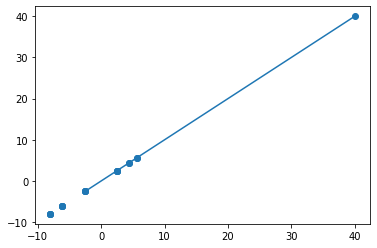

In [6]:
plt.scatter(uu,v)
plt.plot([-2,40],[-2,40])
plt.show()

In [8]:
S.getLambdaGrads(1)

(-0.001443375672974065,
 -0.0014433756729740645,
 -0.002041241452319315,
 -0.0014433756729740645,
 -0.0020412414523193157,
 -0.0014433756729740645,
 -0.0020412414523193144,
 -0.0014433756729740643,
 -0.002041241452319315,
 -0.0014433756729740643,
 -0.002041241452319315,
 -0.0014433756729740643,
 -0.0020412414523193144,
 -0.0014433756729740643,
 -0.0020412414523193144,
 -0.001443375672974064,
 -0.002041241452319315,
 -0.0014433756729740647,
 -0.0020412414523193144,
 -0.0014433756729740643,
 -0.0020412414523193157,
 -0.0014433756729740643,
 -0.002041241452319314,
 -0.001443375672974065,
 -0.002041241452319315,
 -0.001443375672974064,
 -0.002041241452319315,
 -0.0014433756729740638,
 -0.002041241452319315,
 -0.0014433756729740643,
 -0.002041241452319315,
 -0.0014433756729740647,
 -0.0020412414523193144,
 -0.001443375672974064,
 -0.0020412414523193157,
 -0.0014433756729740647,
 -0.0020412414523193157,
 -0.0014433756729740638,
 -0.0020412414523193157,
 -0.0014433756729740647,
 -0.0020412414

In [10]:
eps=1e-8


In [13]:
thetaaux = vect.copy()
thetaaux[ind]=vect[ind]+eps
resultDb.setField(thetaaux,name)
Sp = ShiftOpCs(mesh, model, resultDb)

Lambdap=Sp.getLambdas()

thetaaux = vect.copy()
thetaaux[ind]=vect[ind]-eps
resultDb.setField(thetaaux,name)
Sm = ShiftOpCs(mesh, model, resultDb)
Lambdam=Sm.getLambdas()

In [14]:
a=((np.array(Lambdap)-np.array(Lambdam))/(2*eps))[ind]


In [15]:
#b=S.getLambdaGrad(ipar)[ind]

In [16]:
print(a)
#print(b)

-0.002041242175288005


In [17]:
#a/b

In [18]:
#S.initGradFromMesh(mesh,model,resultDb,NoStat)
Q=PrecisionOpCs(S,model.getCova(0),EPowerPT.ONE)

In [19]:
invect = VectorDouble(Q.getSize())
for i in range(invect.size()):
    invect[i] = np.random.normal(size=(1,))[0]
out = VectorDouble(Q.getSize())
Q.evalDeriv(invect,out,ind,ipar)


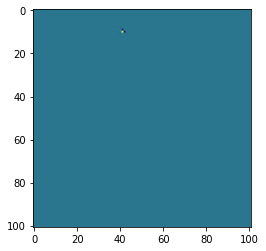

In [20]:
ax = plt.imshow(np.array([i for i in out]).reshape((101,101)))

In [21]:
X = np.random.normal(size=Q.getSize())
Y = np.random.normal(size=Q.getSize())

In [22]:
Qp=PrecisionOpCs(Sp,model.getCova(0),EPowerPT.ONE)
Qm=PrecisionOpCs(Sm,model.getCova(0),EPowerPT.ONE)
Qt = csToTriplet(Q.getQ())
Qpt = csToTriplet(Qp.getQ())
Qmt = csToTriplet(Qm.getQ())
Qmat = sc.sparse.csc_matrix((np.array(Qt.values), (np.array(Qt.rows), np.array(Qt.cols))),
                    shape=(Qt.nrows,Qt.ncols))
Qpmat = sc.sparse.csc_matrix((np.array(Qpt.values), (np.array(Qpt.rows), np.array(Qpt.cols))),
                    shape=(Qpt.nrows,Qpt.ncols))
Qmmat = sc.sparse.csc_matrix((np.array(Qmt.values), (np.array(Qmt.rows), np.array(Qmt.cols))),
                    shape=(Qmt.nrows,Qmt.ncols))

In [23]:
invect = VectorDouble(Q.getSize())
Yvect = VectorDouble(Q.getSize())
invectp = VectorDouble(Qp.getSize())
invectm = VectorDouble(Qp.getSize())
resultp = VectorDouble(Qp.getSize())
resultm = VectorDouble(Qp.getSize())
for i in range(invect.size()):
    invectp[i] = X[i]
    invectm[i] = X[i]
    invect[i] = X[i]
    Yvect[i] = Y[i]
Qp.eval(invectp,resultp)
Qm.eval(invectm,resultm)
aa=(Y.T@resultp - Y.T@resultm)/(2*eps)
aa

-76.15017239004374

In [24]:
out = VectorDouble(Q.getSize())
Q.evalDeriv(invect,out,ind,ipar)
terme1 = Y.T@out


In [27]:
u      = np.zeros(shape=Q.getSize())
u[ind] = S.getLambdaGrads(ipar)[ind]
w      = 2*u/S.getLambdas()

In [28]:
(w*Y)[ind]*(Qmat@X)[ind]

61.04465705000368

In [29]:
terme2 = (w*Y).T@Qmat@(X)

In [30]:
bb=terme1+terme2
aa/bb

0.7575860066034774

In [31]:
terme2

61.04465705000367

In [32]:
result = VectorDouble(Q.getSize() * S.getNModelGradParam())
Q.gradYQX(invect,Yvect,result)

In [33]:
invect[ind]

1.3093947255945568

In [34]:
aa/result[S.getSGradAddress(ind,ipar)]

0.9999811723395391

In [35]:
aa

-76.15017239004374

In [36]:
bb

-100.51686769064221

In [37]:
result[S.getSGradAddress(ind,ipar)]
S.getSGradAddress(ind,ipar)

11252

In [38]:
aa/bb

0.7575860066034774

In [39]:
terme1

-161.5615247406459